In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, auc
from sklearn.metrics import  precision_recall_curve

class CDD_RLR:
    def __init__(self, iterations, alpha, l):
        self.iterations = iterations
        self.alpha = alpha
        self.l = l
        self.beta = None

    def sigmoid(self, x):
        # computes the sigmoid function for input x
        return 1 / (1 + np.exp(-x))

    def p(self, x, beta):
        # computes the probability of the class being 1 given input x and model parameters beta -> y_hat
        return self.sigmoid(x @ beta)

    def weight(self, y_hat):
        # second derivative of the log-likelihood function
        return y_hat * (1 - y_hat)

    def compute_z(self, y_i, x_b, y_hat, w_x):
        # shifts raw log-odds by a scaled version of the residual
        return x_b + (y_i - y_hat) / w_x

    def soft_thresholding(self, x, gamma):
        # applies soft thresholding to the value x with threshold gamma, 
        # reducing |x| > gamma, or making them 0 otherwise
        if x > gamma:
            return x - gamma
        if x < -gamma:
            return x + gamma
        return 0

    def dummy_update(self, X, y, j, beta, alpha, l):
        # Updates the j-th coefficient beta[j] using the coordinate descent algorithm
        x_j = X[:, j]  
        n = len(X)  
        sum_val = 0  
        weights_vector = []

        # --- USING z_i ---

        for i in range(n):
            # Loop through each data point to compute weights and the gradient sum
            x_b = X[i] @ beta # raw log-odds
            y_hat = self.p(X[i], beta) # predicted probability of class 1
            w_x = self.weight(y_hat) # second derivative of the log-likelihood function 
            weights_vector.append(w_x)  
            
            z_i = self.compute_z(y[i], x_b, y_hat, w_x) # shifts raw log-odds by a scaled version of the residual

            # Compute the partial residual, adjusting for beta[j] contribution
            partial_residual_i = z_i - (x_b - beta[j] * x_j[i])

            # Accumulate weighted gradient contribution
            sum_val += w_x * x_j[i] * partial_residual_i  

        # --- NOT USING z_i ---
    
        # for i in range(n):
        #     # Loop through each data point to compute weights and the gradient sum
        #     p_x = self.p(X[i], beta)  # Compute the predicted probability of class 1
        #     w_x = self.weight(p_x)  # Compute the weight based on the probability
        #     weights_vector.append(w_x)  # Store the weight.
            
        #     # Compute the partial residual: difference between actual label and predicted probability,
        #     # adjusted for the influence of the current beta[j]
        #     partial_residual_i = y[i] - p_x + beta[j] * x_j[i]
            
        #     # Accumulate the weighted gradient contribution for the coefficient update
        #     sum_val += w_x * x_j[i] * partial_residual_i      

        # Apply soft-thresholding to enforce L1 (Lasso) regularization
        soft_thresh = self.soft_thresholding(sum_val, alpha * l)
        
         # Compute the denominator for the update:
        # - The sum of squared feature values weighted by the computed weights
        # - L2 (Ridge) penalty term scaled by (1 - alpha), which disappears when alpha = 1 (pure Lasso)
        denominator = np.array(weights_vector) @ (x_j ** 2) + l * (1 - alpha)

        # Return the updated coefficient value
        return soft_thresh / denominator

    def coordinate_descent(self, X, y, alpha, l, beta):
        # Performs coordinate descent optimization on the model parameters beta
        for j in range(len(beta)):
            beta[j] = self.dummy_update(X, y, j, beta, alpha, l)
        return beta

    def fit(self, X_train, y_train):

        self.beta = np.random.rand(X_train.shape[1])

        for _ in range(self.iterations):
            self.beta = self.coordinate_descent(X_train, y_train, self.alpha, self.l, self.beta)

    def predict_proba(self, X_test):
        # Predicts the probabilities for the input X based on the model parameters beta
        return self.p(X_test, self.beta)

    def predict(self, X_test):
        # Predicts the binary class labels (0 or 1) based on the predicted probabilities
        return (self.predict_proba(X_test) >= 0.5).astype(int)

    def validate(self, X_valid, y_valid, measure):
        pass

    def plot(self, measure, X_train, y_train, X_test, y_test):
        lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
        measure_values = [None]*len(lambdas)

        for i, l in enumerate(lambdas):
            cdd_rlr = CDD_RLR(100, 1, l)
            cdd_rlr.fit(X_train, y_train)
            y_pred = cdd_rlr.predict(X_test)
            y_prob = cdd_rlr.predict_proba(X_test)

            if measure == 'accuracy':
                measure_values[i] = np.mean(y_test == y_pred)

            if measure == 'recall':
                measure_values[i] = recall_score(y_test, y_pred)

            if measure == 'precision':
                measure_values[i] = precision_score(y_test, y_pred)

            if measure == 'f1':
                measure_values[i] = f1_score(y_test, y_pred)

            if measure == 'roc_auc':
                measure_values[i] = roc_auc_score(y_test, y_pred)

            if measure == 'auc_spc':
                precision, recall, _ = precision_recall_curve(y_test, y_prob)
                auc_spc = auc(recall, precision)
                measure_values[i] = auc_spc

        plt.figure(figsize=(8, 6))
        plt.scatter(np.log(lambdas), measure_values)

        plt.title(f'{measure.capitalize()} vs Lambda', fontsize=14)
        plt.xlabel('Log of Lambda', fontsize=12)
        plt.ylabel(measure.capitalize(), fontsize=12)

        plt.show()

    def plot_coefficents(self):
        pass

def generate_data(p, n, d, g, random_state=None):
    """
    p - bernoulli distibution pobability of class 1
    n - number of samples
    d - number of features
    g - covariance decay factor (controls how strongly features are correlated in the covariance matrix) 

    0 < p, g < 1
    n, d >= 1
    """

    if random_state is not None:
        np.random.seed(random_state)
    
    Y = np.random.binomial(n=1, p=p, size=n)
    
    mean_0 = np.zeros(d)
    mean_1 = np.array([1/i for i in range(1, d + 1)])

    S = np.fromfunction(lambda i, j: g ** np.abs(i - j), (d, d), dtype=float)
    
    X = np.array([
        np.random.multivariate_normal(mean_0 if y == 0 else mean_1, S)
        for y in Y
    ])
    
    return X, Y

def standardize_matrix(X):
        # Standardizes the input matrix X by subtracting the mean and dividing by the standard deviation
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        return (X - mean) / std

def add_intercept(X):
    # Adds a column of ones to the input matrix X for the intercept term in the linear model
    return np.c_[np.ones(X.shape[0]), X]

def train_test_split(X, y, train_test_ratio):

    train_test_ratio_threshold = round(len(X)*train_test_ratio)

    X_train = X[:train_test_ratio_threshold,:]
    y_train = y[:train_test_ratio_threshold]

    X_test = X[train_test_ratio_threshold:,:]
    y_test = y[train_test_ratio_threshold:]

    return X_train, y_train, X_test, y_test



In [21]:
X, y = generate_data(0.5, 500, 2, 0.8, random_state=12)
X = add_intercept(standardize_matrix(X))

X_train, y_train, X_test, y_test = train_test_split(X, y, 0.8)

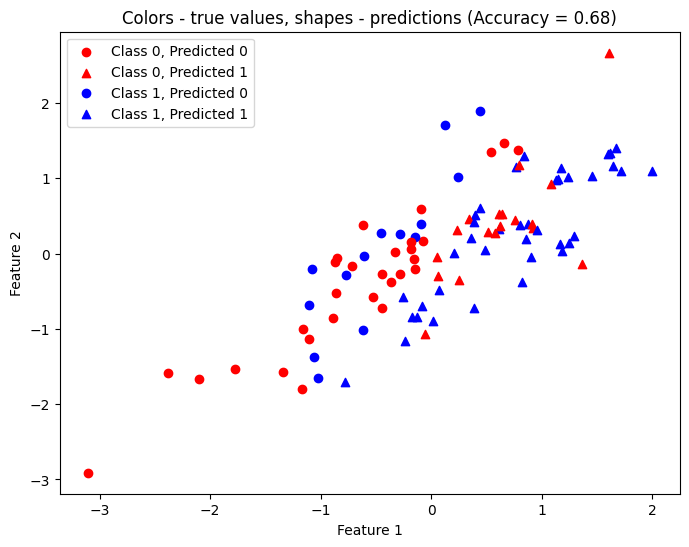

In [29]:
cdd_rlr = CDD_RLR(100, 0.5, 0.5)
cdd_rlr.fit(X_train, y_train)
y_pred = cdd_rlr.predict(X_test)

colors = ['red' if label == 0 else 'blue' for label in y_test]
shapes = ['o' if label == 0 else '^' for label in y_pred]

plt.figure(figsize=(8, 6))
for i in range(len(X_test)):
    plt.scatter(X_test[i, 1], X_test[i, 2], color=colors[i], marker=shapes[i])

plt.scatter([], [], color='red', marker='o', label='Class 0, Predicted 0')  # Przykład klasy 0, przewidywania 0
plt.scatter([], [], color='red', marker='^', label='Class 0, Predicted 1')  # Przykład klasy 0, przewidywania 1
plt.scatter([], [], color='blue', marker='o', label='Class 1, Predicted 0')  # Przykład klasy 1, przewidywania 0
plt.scatter([], [], color='blue', marker='^', label='Class 1, Predicted 1')  # Przykład klasy 1, przewidywania 1

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Colors - true values, shapes - predictions (Accuracy = {np.mean(y_test == y_pred):.2f})')

plt.legend()
plt.show()

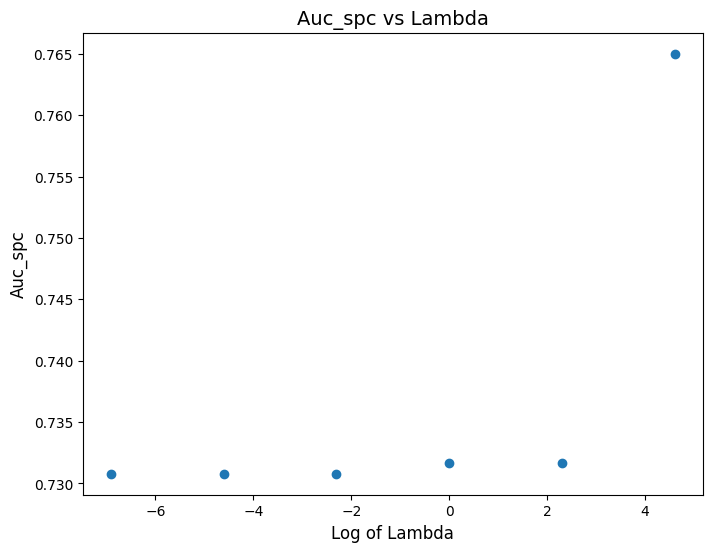

In [ ]:
cdd_rlr = CDD_RLR(100, 0.5, 0.5)

measure = 'accuracy' # accuracy, recall, precision, f1, roc_auc, auc_spc
cdd_rlr.plot(measure, X_train, y_train, X_test, y_test)
